In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=17)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def calc_mean_std(x):
    return (np.mean(x), np.std(x, ddof=1) / np.sqrt(len(x)))

def color_func(p):
    if p > 0.2:
        return 'dodgerblue'
    elif p < 0.05:
        return 'orange'
    else:
        return 'seagreen'

In [7]:
df_matches = pd.read_csv('./matches_flexibility.csv', index_col=0)

In [8]:
df_matches[:3]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID,Huskies_network_params,Opponent_network_params,Huskies_mean_50time,Opponent_mean_50time,time_lag
0,1,Opponent1,win,1,0,home,Coach1,"{'clustering_coeff': 0.09591148659543136, 'sho...","{'clustering_coeff': 0.12727017100674862, 'sho...",691.105482,1487.586192,13.181913
1,2,Opponent2,tie,1,1,away,Coach1,"{'clustering_coeff': 0.13558418994397967, 'sho...","{'clustering_coeff': 0.15137551104001684, 'sho...",1283.008325,709.892932,10.458257
2,3,Opponent3,loss,0,2,away,Coach1,"{'clustering_coeff': 0.12456657946374812, 'sho...","{'clustering_coeff': 0.1305149813894459, 'shor...",786.066763,604.883916,-35.596034


# Adaptibility

## 1. Home/away??

In [10]:
df_matches.groupby('Side').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Side,,,,,,
away,19.578947,0.842105,1.894737,1156.040433,875.060139,1.133102
home,19.421053,1.473684,1.157895,1099.156815,981.738771,-7.919740


In [11]:
df_home = df_matches[df_matches['Side'] == 'home']
df_away = df_matches[df_matches['Side'] == 'away']

In [13]:
df_home[:2]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID,Huskies_network_params,Opponent_network_params,Huskies_mean_50time,Opponent_mean_50time,time_lag
0,1,Opponent1,win,1,0,home,Coach1,"{'clustering_coeff': 0.09591148659543136, 'sho...","{'clustering_coeff': 0.12727017100674862, 'sho...",691.105482,1487.586192,13.181913
3,4,Opponent4,loss,0,3,home,Coach1,"{'clustering_coeff': 0.13348612342014946, 'sho...","{'clustering_coeff': 0.10506435556251267, 'sho...",867.246184,791.518237,-32.366599


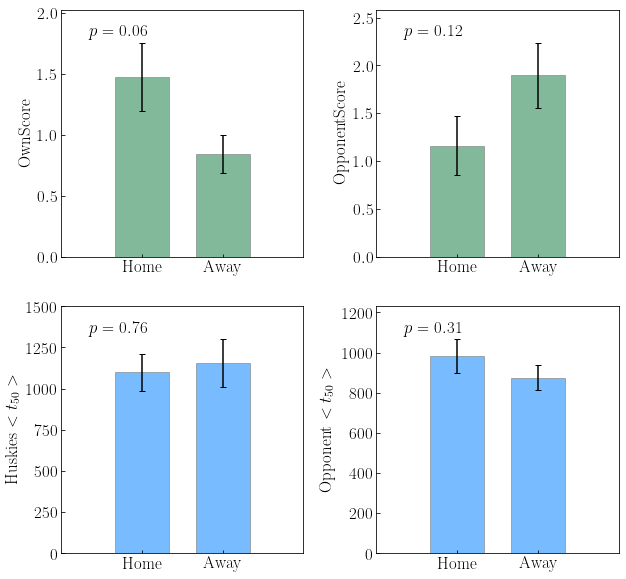

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

from scipy import stats
ylabel_set = ['OwnScore', 'OpponentScore', 
              r'Huskies $<t_{50}>$', r'Opponent $<t_{50}>$']

for ind, column in enumerate(['OwnScore', 'OpponentScore', 
                              'Huskies_mean_50time', 'Opponent_mean_50time']):
    ax = axes[ind // 2, ind % 2]
    
    home = calc_mean_std(df_home[column]) 
    away = calc_mean_std(df_away[column])
    
    levene = stats.levene(df_home[column], df_away[column])
    ttest = stats.ttest_ind(df_home[column], df_away[column], 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Home', 'Away']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [home[0], away[0]], 
           yerr=[home[1], away[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.3)

#plt.savefig('./Draft/top6-network-params.pdf', dpi=200, bbox_inches='tight')
#plt.savefig('./Draft/top6-network-params.png', dpi=200, bbox_inches='tight')

## 2. Coach?

In [32]:
df_matches.groupby('CoachID').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
CoachID,,,,,,
Coach1,5.0,0.777778,2.00,933.327948,913.615427,-8.802039
Coach2,12.0,2.000000,2.00,1316.198610,856.199312,-1.421211
Coach3,26.5,1.125000,1.25,1161.158463,948.985162,-1.775905


In [ ]:
levene = stats.levene(df_home[column], df_away[column])
ttest = stats.ttest_ind(df_home[column], df_away[column], 
                        equal_var=(levene.pvalue > 0.10))

In [38]:
df_matches[df_matches['CoachID'] == 'Coach1'].groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,5.6,0.4,3.0,939.330040,824.991737,-21.938465
tie,5.0,1.0,1.0,1084.037999,842.096903,9.423518
win,3.5,1.5,0.5,767.612669,1206.693176,5.813469


In [39]:
df_matches[df_matches['CoachID'] == 'Coach2'].groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,11.5,0.5,3.0,934.131394,907.847745,11.966461
tie,12.0,2.0,2.0,2428.032266,678.209946,-32.964782
win,12.5,3.5,1.0,1142.348999,893.545563,0.962901


In [40]:
df_matches[df_matches['CoachID'] == 'Coach3'].groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,27.375000,0.625000,2.750000,1288.017201,813.319513,-1.819645
tie,26.142857,0.571429,0.571429,1355.058112,922.212390,1.976383
win,26.000000,2.000000,0.444444,897.584302,1090.400117,-4.655471


## 赛区比赛结果

In [364]:
def color_func(p):
    if p > 0.2:
        return 'dodgerblue'
    elif p < 0.05:
        return 'orange'
    else:
        return 'seagreen'

In [289]:
ranking = {
    'Opponent14': 13,
    'Opponent13': 17,
    'Opponent15': 16,
    'Opponent17': 12,
    'Opponent18': 18,
    'Opponent16': 4,
    'Opponent2': 1,
    'Opponent1': 19,
    'Opponent8': 14,
    'Opponent7': 7,
    'Opponent11': 15,
    'Opponent12': 11,
    'Opponent9': 6,
    'Opponent10': 9,
    'Opponent19': 20,
    'Opponent4': 3,
    'Opponent5': 2,
    'Opponent6': 10,
    'Opponent3': 5
}

In [341]:
ranking = pd.Series(ranking)
ranking = ranking.sort_values()

In [360]:
ind = np.in1d(df_matches['OpponentID'], ranking[ranking <= 5].index.values)
df_win = df_matches.iloc[ind]

column = df_win['Huskies_network_params']
huskies_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

column = df_win['Opponent_network_params']
oppo_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

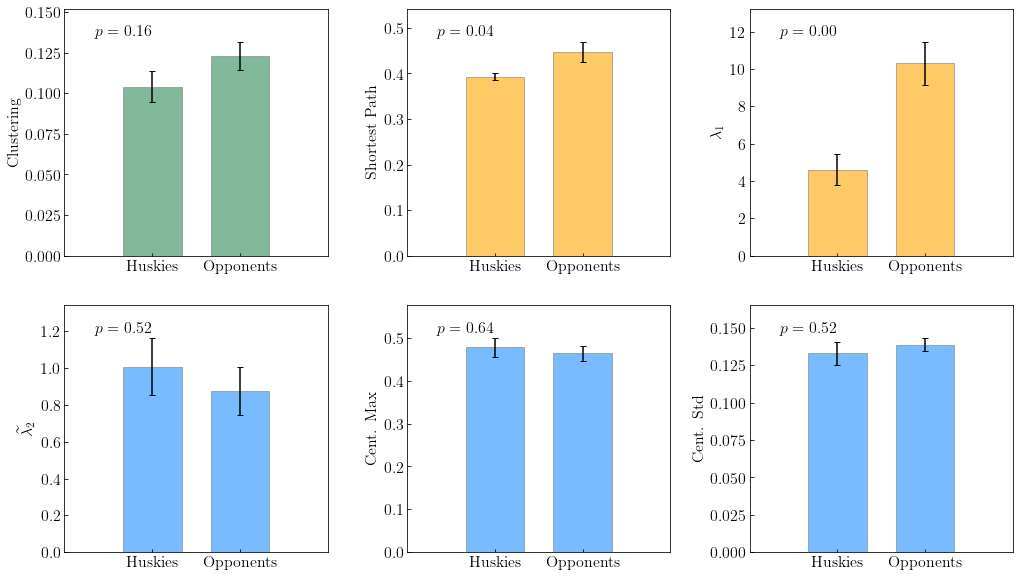

In [365]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']

for ind, column in enumerate(huskies_params.columns):
    ax = axes[ind // 3, ind % 3]
    
    huskie = calc_mean_std(huskies_params[column]) 
    oppo = calc_mean_std(oppo_params[column])
    
    levene = stats.levene(huskies_params[column].values, oppo_params[column].values)
    ttest = stats.ttest_ind(huskies_params[column].values, 
                            oppo_params[column].values, 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('./Draft/top6-network-params.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/top6-network-params.png', dpi=200, bbox_inches='tight')

In [373]:
ind = np.in1d(df_matches['OpponentID'], ranking[ranking >= 15].index.values)
df_win = df_matches.iloc[ind]

column = df_win['Huskies_network_params']
huskies_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

column = df_win['Opponent_network_params']
oppo_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

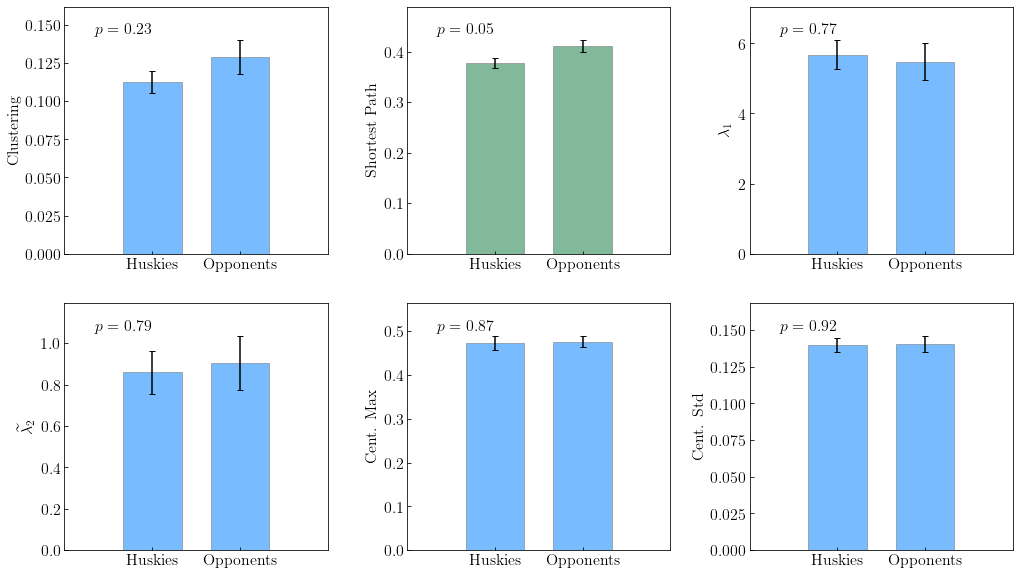

In [375]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']

for ind, column in enumerate(huskies_params.columns):
    ax = axes[ind // 3, ind % 3]
    
    huskie = calc_mean_std(huskies_params[column]) 
    oppo = calc_mean_std(oppo_params[column])
    
    levene = stats.levene(huskies_params[column].values, oppo_params[column].values)
    ttest = stats.ttest_ind(huskies_params[column].values, 
                            oppo_params[column].values, 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('./Draft/bottom6-network-params.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/bottom6-network-params.png', dpi=200, bbox_inches='tight')